In [16]:
import numpy as np
import pandas as pd
import pyvinecopulib as pv

from gcimpute.gaussian_copula import GaussianCopula
from gcimpute.helper_evaluation import get_smae
from gcimpute.helper_data import generate_mixed_from_gc
from gcimpute.helper_mask import mask_MCAR
from vcimpute.helper_mdp import all_mdps, mdp_coords
from vcimpute.helper_datagen import make_complete_data_matrix

In [ ]:
# numba njit

In [40]:
d = 6
X = make_complete_data_matrix(1000, d, 'gaussian', 1)
X_mask = mask_MCAR(X, 0.2)

In [78]:
mdps = all_mdps(X_mask)
Z = []
for i in range(mdps.shape[0]):
    Z.append((1 + np.where(mdps[i])[0]))
Z = np.array(Z, dtype='object')
# Z = Z[np.argsort(list(map(len, Z)))[::-1]]
np.random.shuffle(Z)

order_prefixes = []
matches = []
k = 0
while len(Z) > 0:
    order_prefixes.append(Z[0])
    matches.append([])
    matches[k].append(Z[0])
    remove_indices = [0]
    for i in range(1,len(Z)):
        if len(Z[i]) > len(Z[0]):
            continue
        match = True
        for z1, z2 in zip(Z[0], Z[i]):
            match &= z1 == z2
        if match:
            matches[k].append(Z[i])
            remove_indices.append(i)
    Z = np.delete(Z, remove_indices)
    k += 1

In [79]:
X_imp = np.copy(X_mask)
for order_prefix, sub_matches in zip(order_prefixes, matches): # sort reducing total missing data
    obs_vars = set(1 + np.arange(d)).difference(order_prefix)
    structure = pv.DVineStructure(order=list(order_prefix) + list(obs_vars))
    controls = pv.FitControlsVinecop(family_set=[pv.BicopFamily.gaussian]) # parameter
    cop = pv.Vinecop(structure=structure)
    cop.select(X_imp, controls=controls)
    
    for miss_vars in sub_matches:
        mdp = np.zeros(d, dtype=bool)
        mdp[np.array(list(miss_vars)) - 1] = True
        miss_rows = mdp_coords(X_imp, mdp)
        rb = cop.rosenblatt(X_imp[miss_rows])
        rb[np.isnan(rb)] = np.random.uniform(size=np.count_nonzero(np.isnan(rb)))
        irb = cop.inverse_rosenblatt(rb)
        for i in range(len(miss_rows)):
            X_imp[miss_rows[i], np.array(list(miss_vars))-1] = irb[i, np.array(list(miss_vars))-1]

In [52]:
vc = get_smae(X_imp, X, X_mask)
gc = get_smae(GaussianCopula().fit_transform(X_mask), X, X_mask)

In [53]:
from matplotlib import pyplot as plt

Text(0, 0.5, 'gc')

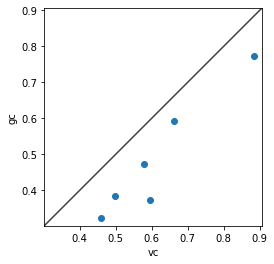

In [54]:
plt.scatter(vc, gc)
ax = plt.gca()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.xlabel('vc')
plt.ylabel('gc')

In [80]:
np.mean(get_smae(X_imp, X, X_mask))

0.6240349540866599

In [81]:
np.mean(get_smae(GaussianCopula().fit_transform(X_mask), X, X_mask))

0.4867195708592243

In [86]:
order_prefixes

[array([2, 4]),
 array([1, 6]),
 array([4, 5, 6]),
 array([4, 6]),
 array([2, 3, 4]),
 array([2, 3, 4, 6]),
 array([1, 3, 5]),
 array([5]),
 array([1, 5, 6]),
 array([3, 4, 5]),
 array([1, 2, 5]),
 array([2, 3, 6]),
 array([3, 4, 6]),
 array([1, 2, 6]),
 array([3, 5, 6]),
 array([1, 3, 5, 6]),
 array([1, 4, 6]),
 array([2, 6]),
 array([1, 4, 5, 6]),
 array([1, 3, 4, 6]),
 array([6]),
 array([3, 4, 5, 6]),
 array([2, 4, 5]),
 array([2, 5, 6]),
 array([3, 6]),
 array([1, 2, 3, 4]),
 array([2, 4, 6]),
 array([1, 3, 6]),
 array([1, 3, 4, 5, 6]),
 array([1, 2, 5, 6]),
 array([2, 4, 5, 6]),
 array([2, 3, 5]),
 array([2, 3, 5, 6]),
 array([5, 6])]

In [85]:
matches

[[array([2, 4]), array([2])],
 [array([1, 6]), array([1])],
 [array([4, 5, 6]), array([4, 5]), array([4])],
 [array([4, 6])],
 [array([2, 3, 4]), array([2, 3])],
 [array([2, 3, 4, 6])],
 [array([1, 3, 5]), array([1, 3])],
 [array([5])],
 [array([1, 5, 6]), array([1, 5])],
 [array([3, 4, 5]), array([3, 4]), array([3])],
 [array([1, 2, 5]), array([1, 2])],
 [array([2, 3, 6])],
 [array([3, 4, 6])],
 [array([1, 2, 6])],
 [array([3, 5, 6]), array([3, 5])],
 [array([1, 3, 5, 6])],
 [array([1, 4, 6]), array([1, 4])],
 [array([2, 6])],
 [array([1, 4, 5, 6]), array([1, 4, 5])],
 [array([1, 3, 4, 6]), array([1, 3, 4])],
 [array([6])],
 [array([3, 4, 5, 6])],
 [array([2, 4, 5])],
 [array([2, 5, 6]), array([2, 5])],
 [array([3, 6])],
 [array([1, 2, 3, 4]), array([1, 2, 3])],
 [array([2, 4, 6])],
 [array([1, 3, 6])],
 [array([1, 3, 4, 5, 6])],
 [array([1, 2, 5, 6])],
 [array([2, 4, 5, 6])],
 [array([2, 3, 5])],
 [array([2, 3, 5, 6])],
 [array([5, 6])]]